In [1]:
# Importamos todas las bibliotecas necesarias

#import copy
import os
import random
#import shutil
#import zipfile
#from math import atan2, cos, sin, sqrt, pi, log

#import cv2
import matplotlib.pyplot as plt
#import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
#from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
#from torchvision import transforms
from tqdm import tqdm

In [2]:
# Inicializamos el generador de numeros aleatorios
random.seed(1234)
torch.manual_seed(1234)

In [3]:
class DoubleConv(torch.nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(torch.nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x =  self.conv(x)

        #x = torch.softmax(x, dim=1)
        return x


class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



In [4]:
# Probamos el modelo
input_image = torch.rand((1,3,512,512))
model = UNet(3,1)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 1, 512, 512]) as a result

torch.Size([1, 1, 512, 512])


In [5]:
# Defino los path de las imagenes y las mascaras
path_images = 'C:/Users/gtoma/Master_AI_Aplicada/UEM_Master_AI_07042025/UEM_Trabajo/Sesiones_UEM/Manuel_Garcia_VISION/Actividad_2_UNet/data_flood/data/Image/'
path_masks = 'C:/Users/gtoma/Master_AI_Aplicada/UEM_Master_AI_07042025/UEM_Trabajo/Sesiones_UEM/Manuel_Garcia_VISION/Actividad_2_UNet/data_flood/data/Mask/'

In [6]:
# Vamos a crear una clase para cargar las imagenes y las mascaras
class FloodDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform

        self.images = os.listdir(images_path)
        self.masks = os.listdir(masks_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.images_path, self.images[idx])
        mask_name = os.path.join(self.masks_path, self.masks[idx])

        image = Image.open(image_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print("GPU is available")
    num_workers = torch.cuda.device_count() * 4
    print(f"Number of workers: {num_workers}")

GPU is available
Number of workers: 4


In [8]:
Batch_Size = 16
Learning_Rate = 0.00001 
Num_Epochs = 25

In [9]:
print("Hiperparametros:")
print(f"Batch Size: {Batch_Size}")
print(f"Learning Rate: {Learning_Rate}")
print(f"Num Epochs: {Num_Epochs}")
print(f"Device: {device}")
print(f"Num Workers: {num_workers}")

Hiperparametros:
Batch Size: 16
Learning Rate: 1e-05
Num Epochs: 25
Device: cuda
Num Workers: 4


In [10]:
# Ya podemos crear el dataset sin Data Augmentation
# Definimos la transformacion
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Hacemos data augmentation asegurandonos que la mascara y la imagen se transforman de la misma manera
#data_augmentation = transforms.Compose([
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#])  
# Añadimos la data augmentation a la transformacion
#transform = transforms.Compose([
#    transforms.Resize((512, 512)),
#    data_augmentation,
#    transforms.ToTensor()
#])

# Cargamos el dataset
dataset = FloodDataset(images_path=path_images, masks_path=path_masks, transform=transform)

# Dividimos el dataset en train y test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1234))

# Cargamos el dataset en un dataloader
train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=False)

In [11]:
# Vamos a mostrar el numero de batches
print(f"Numero de batches de train: {len(train_loader)}")
print(f"Numero de batches de test: {len(test_loader)}")

Numero de batches de train: 15
Numero de batches de test: 4


In [12]:
# Visualizamos el dataset
def show_batch(dl):
    for images, masks in dl:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(images[1].permute(1, 2, 0))
        ax[0].set_title('Image')
        ax[1].imshow(masks[1].permute(1, 2, 0), cmap='gray')
        ax[1].set_title('Mask')
        plt.show()
        break



Visualizando la primera imagen y mascara de train


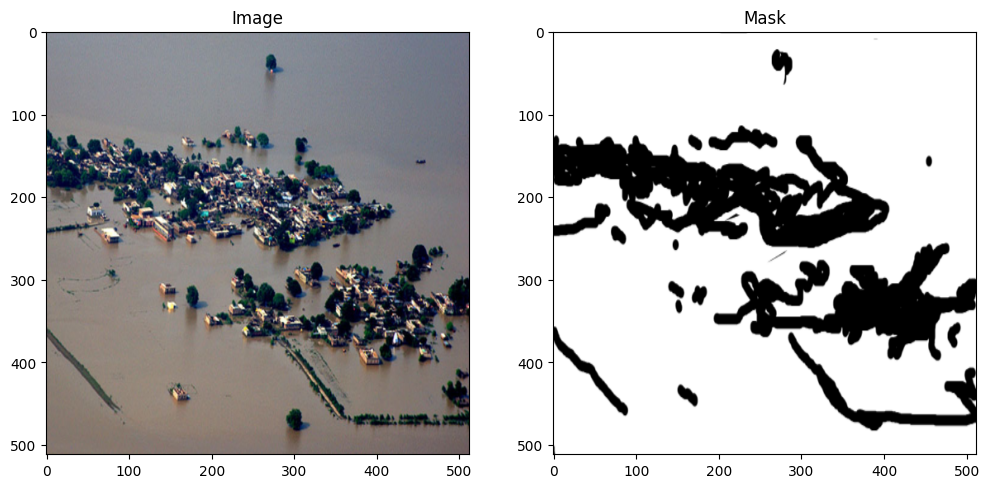

In [13]:
# Visualizamos la primera imagen y mascara de train
print("Visualizando la primera imagen y mascara de train")
show_batch(train_loader)


Visualizando la primera imagen y mascara de test


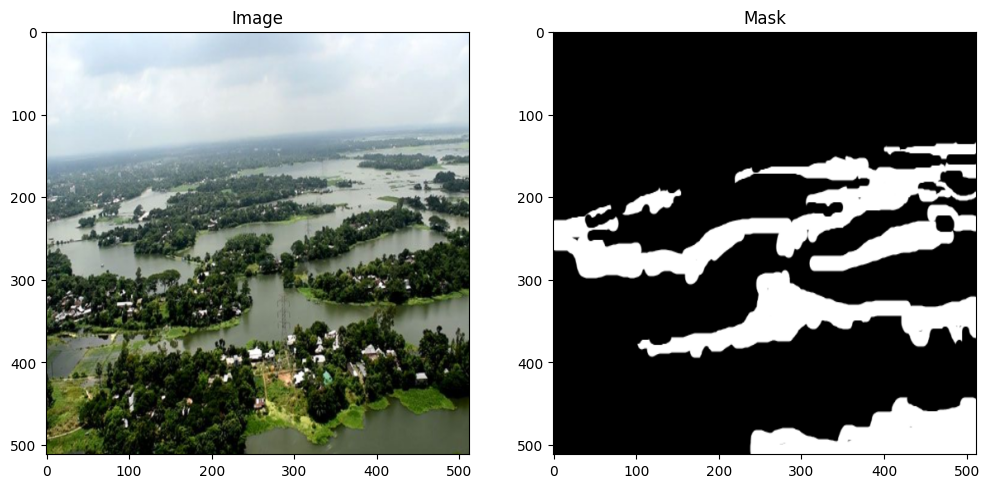

In [14]:
# Visualizamos la primera imagen y mascara de test
print("Visualizando la primera imagen y mascara de test")
show_batch(test_loader)

In [15]:
# Definimos el modelo, el optimizador y la funcion de perdida y cargamos el modelo en la GPU
model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=Learning_Rate)
criterion = nn.BCEWithLogitsLoss()

In [16]:
#torch.cuda.empty_cache()

In [17]:
# Vamos a definir un bloque de entrenamiento y evaluacion del modelo guaradando los datos para las graficas de perdida y accuracy utilizando el IOU
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    iou_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluamos el modelo
        model.eval()
        running_loss = 0.0
        iou_score_epoch = 0.00

        with torch.no_grad():
            for images, masks in tqdm(test_loader):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                running_loss += loss.item()

                # Calculamos el IOU
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()
                intersection = (outputs * masks).sum()
                union = outputs.sum() + masks.sum() - intersection
                iou_score = intersection / union
                iou_score_epoch += iou_score.item()

        # Guardamos la perdida y el IOU    
        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        iou_scores.append(iou_score_epoch / len(test_loader))

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, IOU: {iou_scores[-1]:.4f}")

    return train_losses, test_losses, iou_scores

In [18]:
# Vamos a entrenar el modelo
train_losses, test_losses, iou_scores = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=Num_Epochs)

100%|██████████| 4/4 [00:42<00:00, 10.57s/it]


Epoch 1/25, Train Loss: 0.6943, Test Loss: 0.6885, IOU: 0.4853


100%|██████████| 4/4 [00:40<00:00, 10.22s/it]


Epoch 2/25, Train Loss: 0.6140, Test Loss: 0.6805, IOU: 0.4650


100%|██████████| 4/4 [00:40<00:00, 10.18s/it]


Epoch 3/25, Train Loss: 0.5515, Test Loss: 0.6151, IOU: 0.5462


100%|██████████| 4/4 [00:44<00:00, 11.05s/it]


Epoch 4/25, Train Loss: 0.5010, Test Loss: 0.5183, IOU: 0.6153


100%|██████████| 4/4 [00:38<00:00,  9.74s/it]


Epoch 5/25, Train Loss: 0.4630, Test Loss: 0.4572, IOU: 0.6556


100%|██████████| 4/4 [00:41<00:00, 10.45s/it]


Epoch 6/25, Train Loss: 0.4312, Test Loss: 0.4281, IOU: 0.6710


100%|██████████| 4/4 [00:41<00:00, 10.44s/it]


Epoch 7/25, Train Loss: 0.4046, Test Loss: 0.4481, IOU: 0.6542


100%|██████████| 4/4 [00:40<00:00, 10.07s/it]


Epoch 8/25, Train Loss: 0.3836, Test Loss: 0.4129, IOU: 0.6790


100%|██████████| 4/4 [00:42<00:00, 10.67s/it]


Epoch 9/25, Train Loss: 0.3795, Test Loss: 0.4007, IOU: 0.6847


100%|██████████| 4/4 [00:41<00:00, 10.47s/it]


Epoch 10/25, Train Loss: 0.3668, Test Loss: 0.4076, IOU: 0.6817


100%|██████████| 4/4 [00:40<00:00, 10.25s/it]


Epoch 11/25, Train Loss: 0.3538, Test Loss: 0.3829, IOU: 0.6810


100%|██████████| 4/4 [00:44<00:00, 11.19s/it]


Epoch 12/25, Train Loss: 0.3507, Test Loss: 0.3830, IOU: 0.6853


100%|██████████| 4/4 [00:42<00:00, 10.53s/it]


Epoch 13/25, Train Loss: 0.3411, Test Loss: 0.3771, IOU: 0.6920


100%|██████████| 4/4 [00:38<00:00,  9.59s/it]


Epoch 14/25, Train Loss: 0.3378, Test Loss: 0.3701, IOU: 0.6949


100%|██████████| 4/4 [00:41<00:00, 10.36s/it]


Epoch 15/25, Train Loss: 0.3248, Test Loss: 0.3654, IOU: 0.6911


100%|██████████| 4/4 [00:40<00:00, 10.02s/it]


Epoch 16/25, Train Loss: 0.3216, Test Loss: 0.3612, IOU: 0.7073


100%|██████████| 4/4 [00:44<00:00, 11.15s/it]


Epoch 17/25, Train Loss: 0.3150, Test Loss: 0.3655, IOU: 0.6909


100%|██████████| 4/4 [00:44<00:00, 11.11s/it]


Epoch 18/25, Train Loss: 0.3130, Test Loss: 0.3807, IOU: 0.6955


100%|██████████| 4/4 [00:43<00:00, 10.79s/it]


Epoch 19/25, Train Loss: 0.3252, Test Loss: 0.3751, IOU: 0.7015


100%|██████████| 4/4 [00:45<00:00, 11.44s/it]


Epoch 20/25, Train Loss: 0.3108, Test Loss: 0.3658, IOU: 0.7151


100%|██████████| 4/4 [00:44<00:00, 11.06s/it]


Epoch 21/25, Train Loss: 0.3100, Test Loss: 0.3637, IOU: 0.7081


100%|██████████| 4/4 [00:34<00:00,  8.66s/it]


Epoch 22/25, Train Loss: 0.2996, Test Loss: 0.3564, IOU: 0.7131


100%|██████████| 4/4 [00:34<00:00,  8.61s/it]


Epoch 23/25, Train Loss: 0.2957, Test Loss: 0.3487, IOU: 0.7154


100%|██████████| 4/4 [00:34<00:00,  8.59s/it]


Epoch 24/25, Train Loss: 0.2967, Test Loss: 0.3571, IOU: 0.7005


100%|██████████| 4/4 [00:34<00:00,  8.58s/it]

Epoch 25/25, Train Loss: 0.2913, Test Loss: 0.3440, IOU: 0.7070


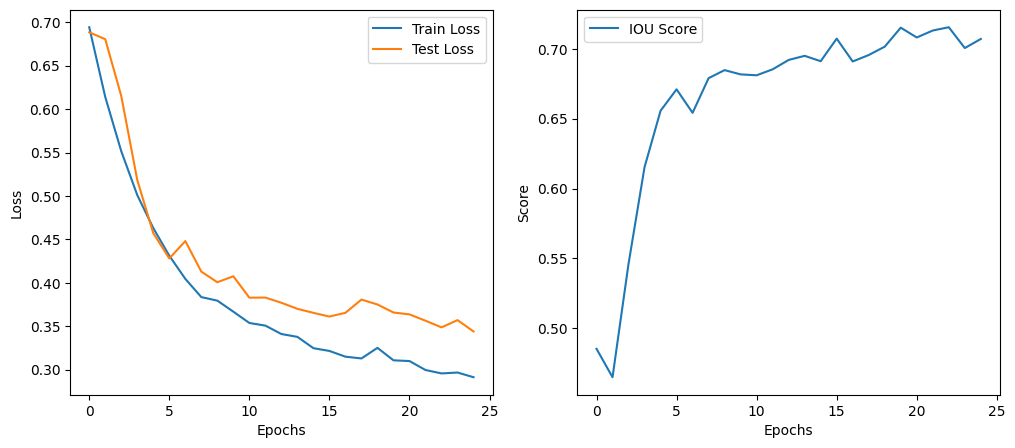

In [19]:
# Vamos a guardar la curva de loss vs epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(iou_scores, label='IOU Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.savefig('C:/Users/gtoma/Master_AI_Aplicada/UEM_Master_AI_07042025/UEM_Trabajo/Sesiones_UEM/Manuel_Garcia_VISION/Actividad_2_UNet/curvas.png')

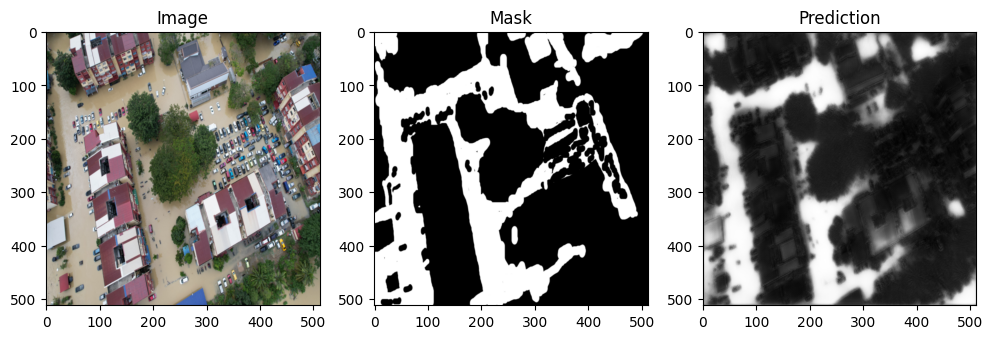

In [20]:
# Vamos a mostrar una imagen y su prediccion
def show_prediction(model, image, mask):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('Image')
    ax[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(output, cmap='gray')
    ax[2].set_title('Prediction')
    plt.show()
    
for images, masks in test_loader:
    show_prediction(model, images[0], masks[0])
    break

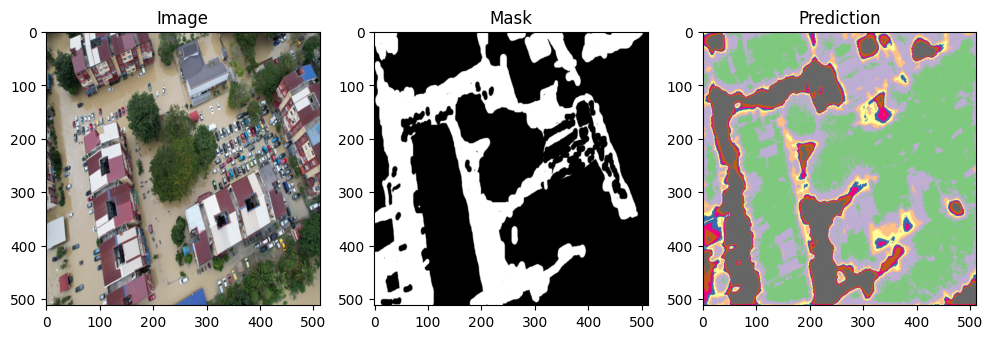

In [21]:
# Mostramos la prediccion en tonos de gris y en color
def show_prediction_color(model, image, mask):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('Image')
    ax[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(output, cmap='Accent')
    ax[2].set_title('Prediction')
    plt.show()

for images, masks in test_loader:
    show_prediction_color(model, images[0], masks[0])
    break

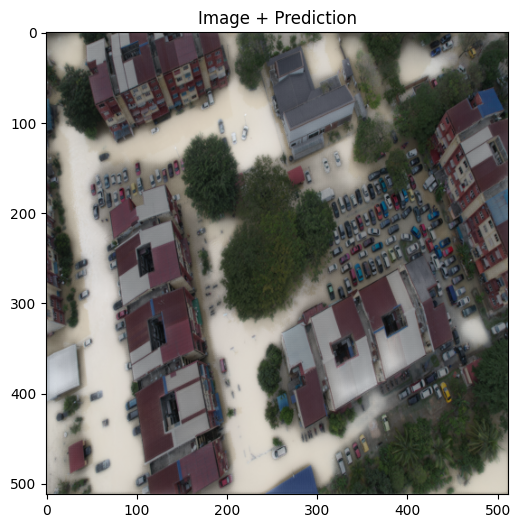

In [22]:
# Mostramos una imagen y su prediccion superpuesta en transparente
def show_prediction_transparent(model, image, mask):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax.imshow(output, cmap='gray', alpha=0.5)
    ax.set_title('Image + Prediction')
    plt.show()
    
for images, masks in test_loader:
    show_prediction_transparent(model, images[0], masks[0])
    break

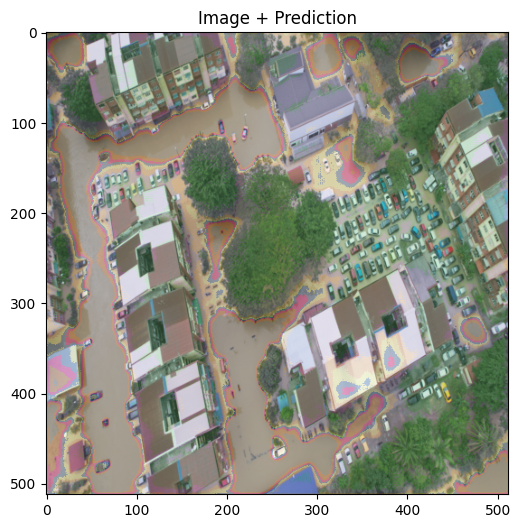

In [23]:
# Mostramos una imagen y su prediccion superpuesta en transparente en color
def show_prediction_transparent_color(model, image, mask):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax.imshow(output, cmap='Accent', alpha=0.3)
    ax.set_title('Image + Prediction')
    plt.show()
    
for images, masks in test_loader:
    show_prediction_transparent_color(model, images[0], masks[0])
    break


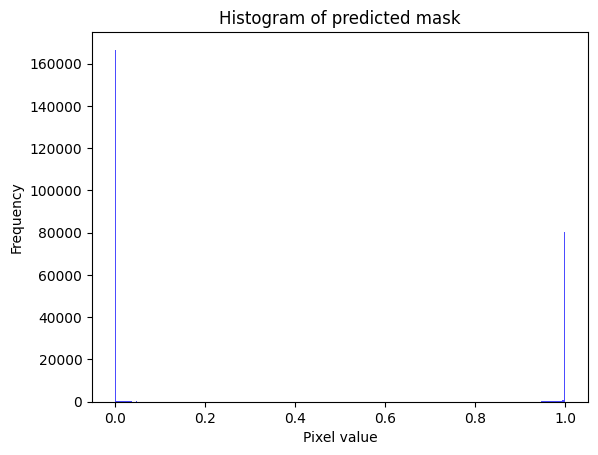

In [24]:
# Mostramos el histograma de los pixeles de la mascara predicha
def show_histogram(image):
    plt.hist(image.flatten(), bins=256, range=(0, 1), color='blue', alpha=0.7)
    plt.title('Histogram of predicted mask')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()
    
for images, masks in test_loader:
    show_histogram(masks[0].cpu().numpy())
    break

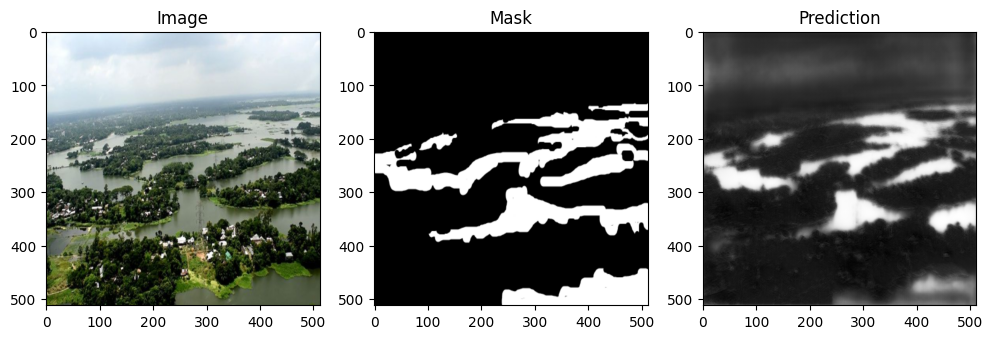

In [25]:
# Vamos a mostrar una imagen y su prediccion
for images, masks in test_loader:
    show_prediction(model, images[1], masks[1])
    break

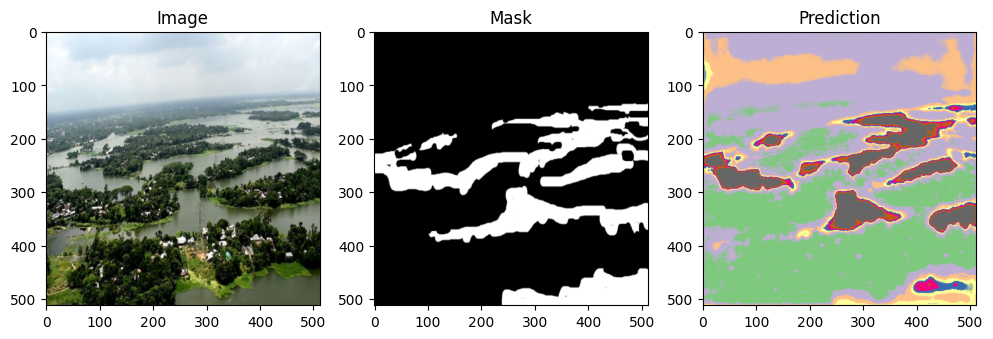

In [26]:
# Mostramos la prediccion en tonos de gris y en color
for images, masks in test_loader:
    show_prediction_color(model, images[1], masks[1])
    break

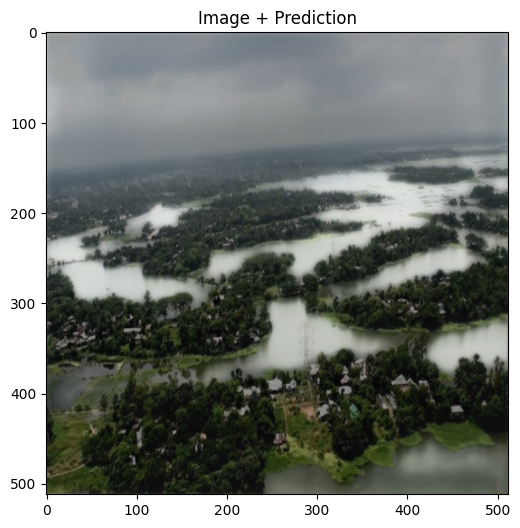

In [27]:
# Mostramos una imagen y su prediccion superpuesta en transparente    
for images, masks in test_loader:
    show_prediction_transparent(model, images[1], masks[1])
    break

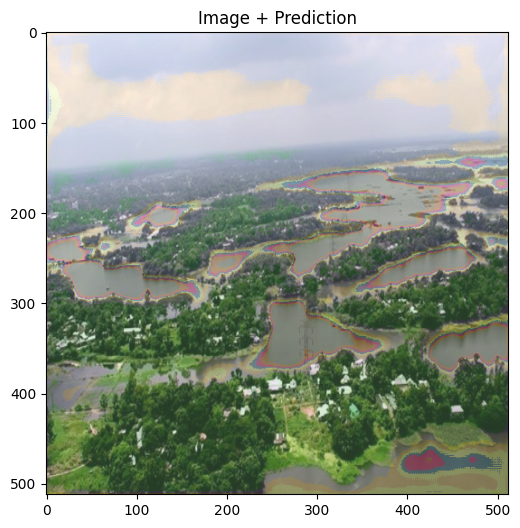

In [28]:
# Mostramos una imagen y su prediccion superpuesta en transparente en color    
for images, masks in test_loader:
    show_prediction_transparent_color(model, images[1], masks[1])
    break

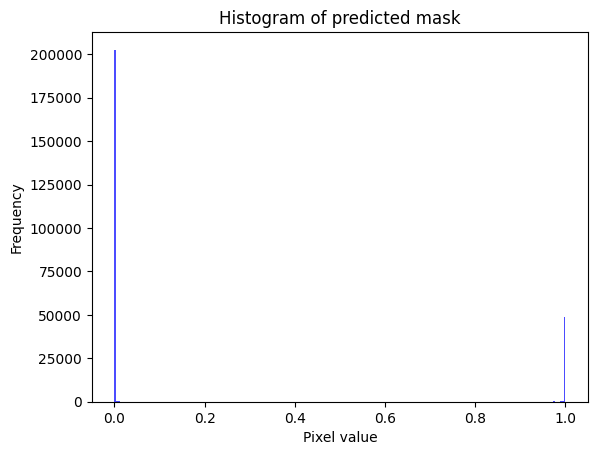

In [29]:
# Mostramos el histograma de la mascara
for images, masks in test_loader:
    show_histogram(masks[1].cpu().numpy())
    break

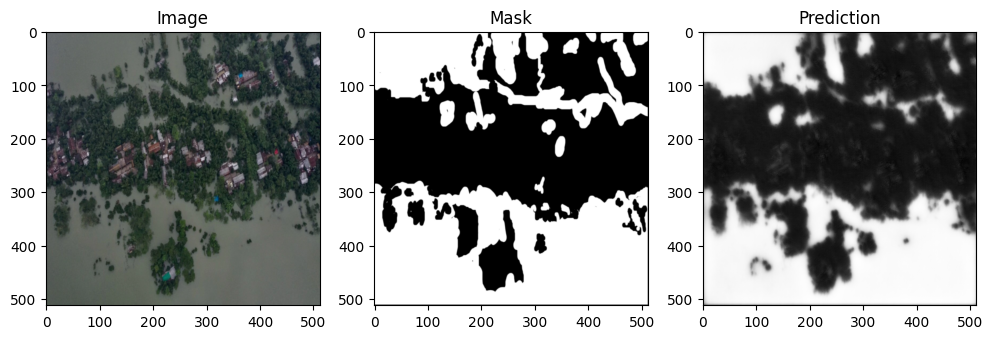

In [30]:
# Vamos a mostrar una imagen y su prediccion
for images, masks in test_loader:
    show_prediction(model, images[2], masks[2])
    break

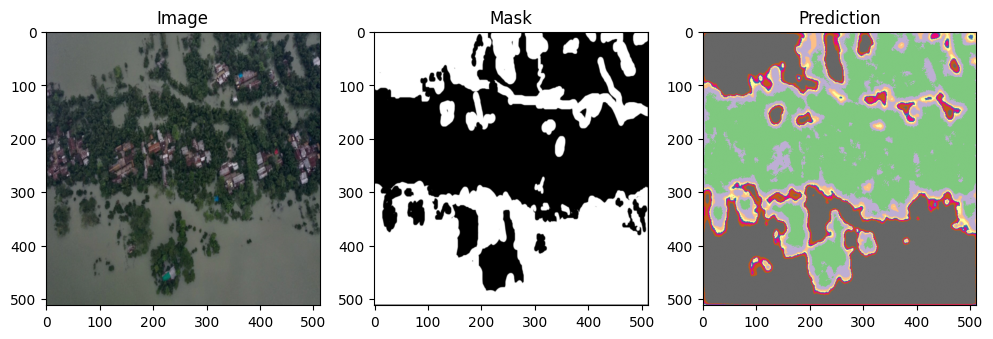

In [31]:
# Mostramos la prediccion en tonos de gris y en color
for images, masks in test_loader:
    show_prediction_color(model, images[2], masks[2])
    break

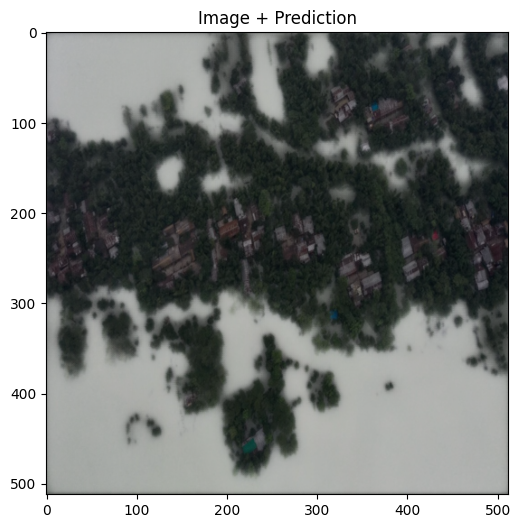

In [32]:
# Mostramos una imagen y su prediccion superpuesta en transparente    
for images, masks in test_loader:
    show_prediction_transparent(model, images[2], masks[2])
    break

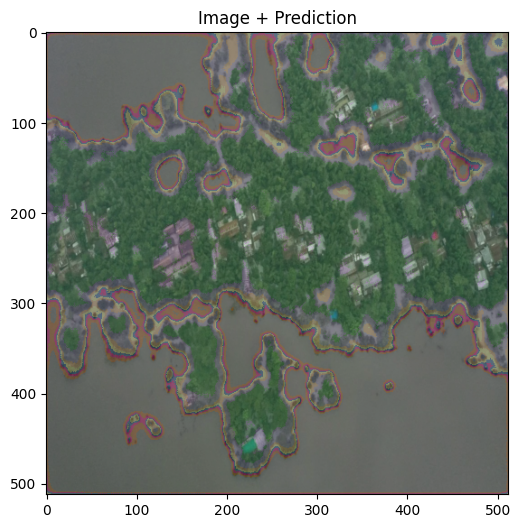

In [33]:
# Mostramos una imagen y su prediccion superpuesta en transparente en color    
for images, masks in test_loader:
    show_prediction_transparent_color(model, images[2], masks[2])
    break

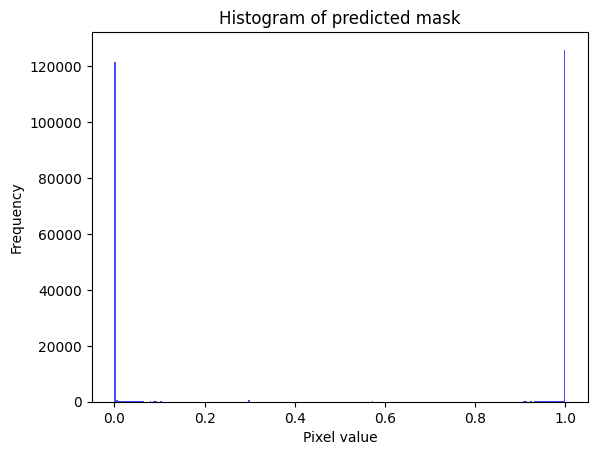

In [34]:
# Mostramos el histograma de la mascara
for images, masks in test_loader:
    show_histogram(masks[2].cpu().numpy())
    break

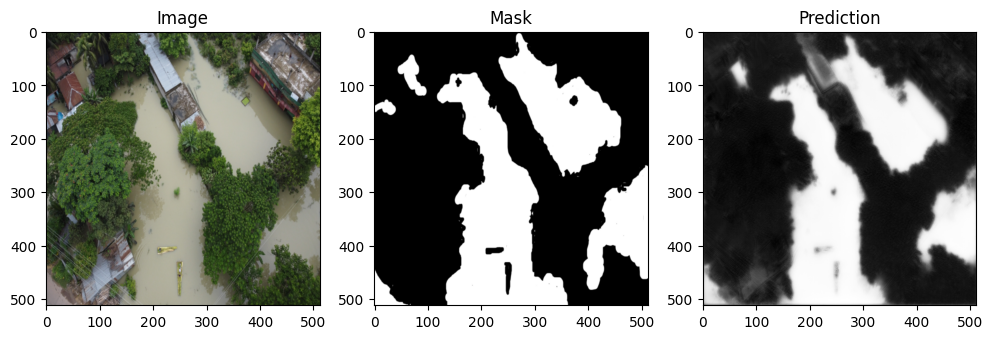

In [35]:
# Vamos a mostrar una imagen y su prediccion
for images, masks in test_loader:
    show_prediction(model, images[3], masks[3])
    break

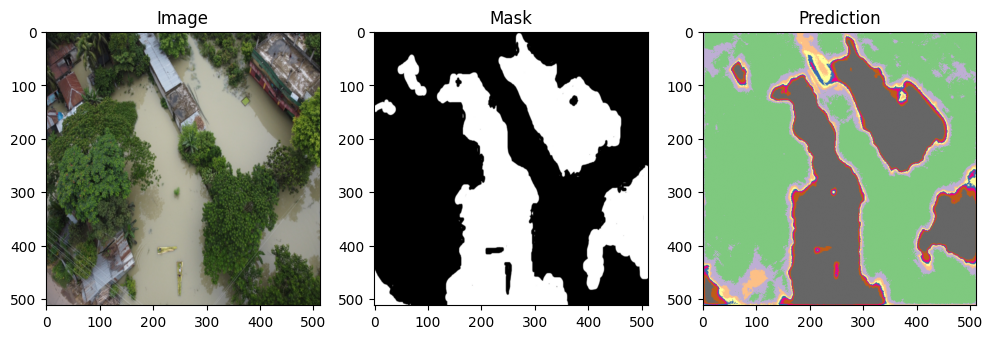

In [36]:
# Mostramos la prediccion en tonos de gris y en color
for images, masks in test_loader:
    show_prediction_color(model, images[3], masks[3])
    break

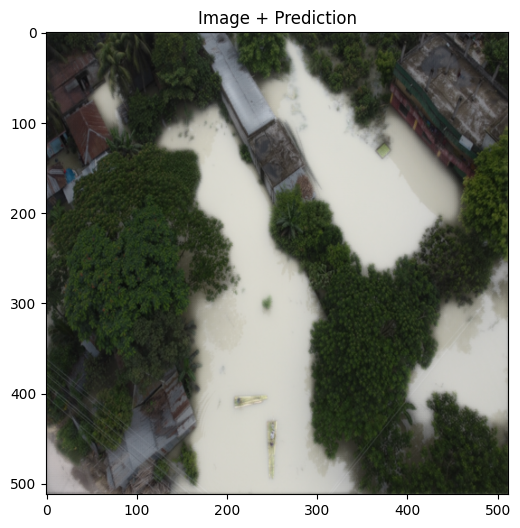

In [37]:
# Mostramos una imagen y su prediccion superpuesta en transparente    
for images, masks in test_loader:
    show_prediction_transparent(model, images[3], masks[3])
    break

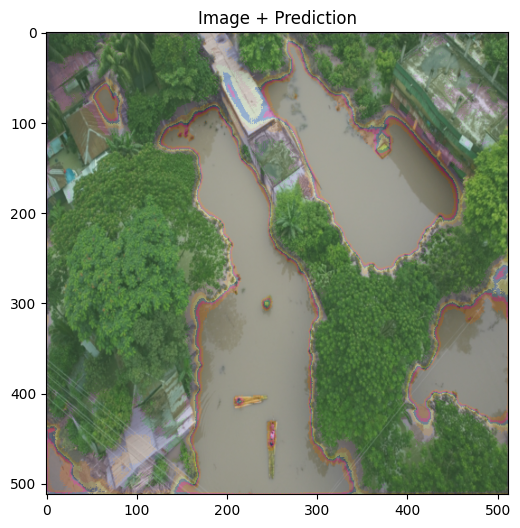

In [38]:
# Mostramos una imagen y su prediccion superpuesta en transparente en color    
for images, masks in test_loader:
    show_prediction_transparent_color(model, images[3], masks[3])
    break

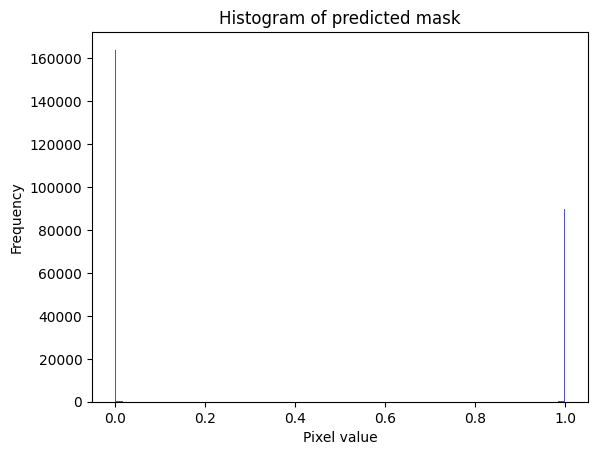

In [39]:
# Mostramos el histograma de la mascara
for images, masks in test_loader:
    show_histogram(masks[3].cpu().numpy())
    break